# Playground for Interpretting Clusters

- Stephen W. Thomas
- Used for MMA 869, MMAI 869, and GMMA 869

In [1]:
import datetime
print(datetime.datetime.now())

2020-07-02 14:29:40.838751


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Default plot settings
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16


plt.rc('figure', figsize=[8.0, 5.0])     # controls the size of the figure
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', grid=True)

# Read in Data

This data is from the UCI repo: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

The features are described as follows:

- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')


(There are others, but we will remove for the purposes of this study.)

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/stepthom/869_course/main/data/bank.csv")

# drop the target feature; not needed for clustering
df = df.drop(['default', 'y', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome'], axis=1)

df.shape
df.info()
df.head(n=10)

#Small sample for now
df = df.iloc[0:1000,]

(4521, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   balance    4521 non-null   int64 
 5   housing    4521 non-null   object
 6   loan       4521 non-null   object
dtypes: int64(2), object(5)
memory usage: 247.4+ KB


,age,job,marital,education,balance,housing,loan
0,30,unemployed,married,primary,1787,no,no
1,33,services,married,secondary,4789,yes,yes
2,35,management,single,tertiary,1350,yes,no
3,30,management,married,tertiary,1476,yes,yes
4,59,blue-collar,married,secondary,0,yes,no
5,35,management,single,tertiary,747,no,no
6,36,self-employed,married,tertiary,307,yes,no
7,39,technician,married,secondary,147,yes,no
8,41,entrepreneur,married,tertiary,221,yes,no
9,43,services,married,primary,-88,yes,yes


# Data Description

In [5]:
# Let's figure how many features there are, and which are categorical vs numeric, and save for later

n_features = df.shape[1]

cat_col_names = list(df.select_dtypes(include=np.object).columns)
num_col_names = list(df.select_dtypes(include=np.number).columns)

print('cat_col_names: {}'.format(cat_col_names))
print('num_col_names: {}'.format(num_col_names))

cat_col_names: ['job', 'marital', 'education', 'housing', 'loan']
num_col_names: ['age', 'balance']


In [6]:
# Descriptive stats of the numeric features
df.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
age,1000.0,41.174,10.463135,19.0,33.0,40.0,49.00,83.0
balance,1000.0,1498.592,2778.416508,-1680.0,81.0,462.0,1526.75,26965.0


In [7]:
# Descriptive stats of the categorical features
df.describe(include=[np.object]).transpose()

,count,unique,top,freq
job,1000,12,management,221
marital,1000,3,married,595
education,1000,4,secondary,492
housing,1000,2,yes,554
loan,1000,2,no,836


# Data Preprocessing

In [8]:
from sklearn.preprocessing import StandardScaler

X_num = df[num_col_names].to_numpy()
X_cat = df[cat_col_names].to_numpy()

# Be sure to scale all numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

X = np.concatenate((X_num, X_cat), axis=1)
X

array([[-1.0684742983341025, 0.10385495170152446, 'unemployed', ...,
        'primary', 'no', 'no'],
       [-0.78160989033318, 1.1848671462591531, 'services', ...,
        'secondary', 'yes', 'yes'],
       [-0.5903669516658984, -0.05350758294926957, 'management', ...,
        'tertiary', 'yes', 'no'],
       ...,
       [-0.6859884209995392, -0.2972934775913464, 'management', ...,
        'tertiary', 'yes', 'yes'],
       [-0.11225960499769427, -0.662792270887813, 'services', ...,
        'secondary', 'yes', 'no'],
       [-2.0246889916705104, -0.43485065891080477, 'student', ...,
        'secondary', 'no', 'no']], dtype=object)

# Distance Calculation

Since this dataset has both categorical and numeric features, and no distance method exists in scipy or scikit-learn to handle mixed types, we will define our own called `custom_dist`. It will use Euclidean distance on numeric features, Hamming distance on categorical features, and take the weighted average of the two.

In [9]:
from scipy.spatial import distance

# Now, let's define our own function to handle both types of features

def custom_dist(x1, x2, cat_cols=None, num_cols=None):
   
    n = len(x1)
    #print(x1)
    #print(num_cols)
    #print(x1[num_cols])
    #print(x2)

    dist_num = distance.euclidean(x1[num_cols], x2[num_cols])
    #print(dist_num)
    dist_cat = distance.hamming(x1[cat_cols], x2[cat_cols])
    #print(dist_cat)
    
    dist = (dist_num*sum(num_cols) + dist_cat*sum(cat_cols)) / n
    #print(dist)
    return dist

In [10]:
# Now, we call our custom distance metric on all pairs of rows in our dataset to create our own custom distance matrix.

from scipy.spatial.distance import pdist

cat_cols = [type(x)==str for x in X[1,:]]
num_cols = [not x for x in cat_cols]

# Warning: pdist is kind of slow
Y = pdist(X, custom_dist, cat_cols=cat_cols, num_cols=num_cols)

In [11]:
# Perform hierarchical clustering, using our custom-built distance matrix.

import scipy.cluster

aggl = scipy.cluster.hierarchy.linkage(Y, method='ward')

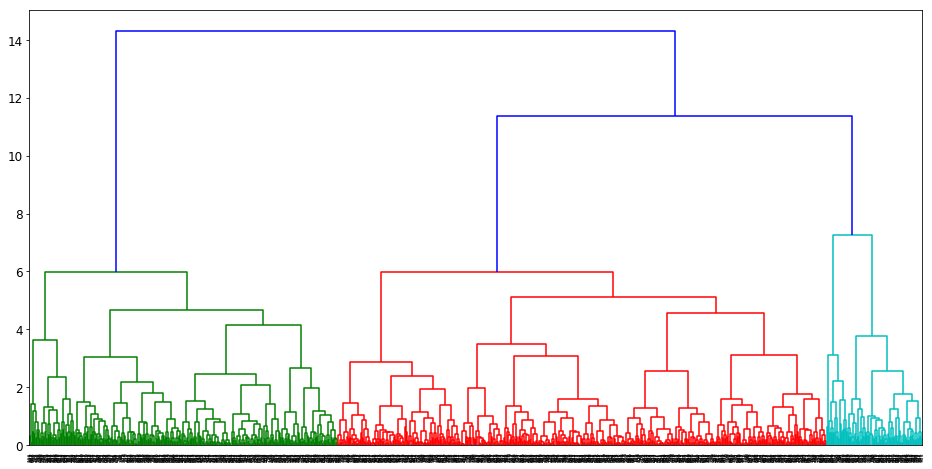

In [12]:
plt.figure(figsize=(16, 8));
plt.grid(False)
dend = scipy.cluster.hierarchy.dendrogram(aggl); 

In [13]:
# Let's find K=5 clusters
K=5
labels = scipy.cluster.hierarchy.fcluster(aggl, K, criterion="maxclust")

## For Each Cluster, Show Textual Feature Stats

In [14]:
from scipy import stats
import seaborn as sns

pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print('All Data:')
print('Number of Instances: {}'.format(X.shape[0]))
df.describe(include=[np.number]).transpose()
df.describe(include=[np.object]).transpose()
for col in cat_col_names:
    df[col].value_counts()


for i, label in enumerate(set(labels)):
    n = df.iloc[labels==label].shape[0]
      
    print('\nCluster {}:'.format(label))
    print('Number of Instances: {}'.format(n))

    df.iloc[labels==label].describe(include=[np.number]).transpose()
    df.iloc[labels==label].describe(include=[np.object]).transpose()
    for col in cat_col_names:
        df.iloc[labels==label][col].value_counts()


All Data:
Number of Instances: 1000


C:\Users\st50\AppData\Roaming\Python\Python36\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


,count,mean,std,min,25%,50%,75%,max
age,1000.00,41.17,10.46,19.00,33.00,40.00,49.00,83.00
balance,1000.00,1498.59,2778.42,-1680.00,81.00,462.00,1526.75,26965.00


,count,unique,top,freq
job,1000,12,management,221
marital,1000,3,married,595
education,1000,4,secondary,492
housing,1000,2,yes,554
loan,1000,2,no,836


management       221
blue-collar      206
technician       181
admin.            96
services          76
self-employed     53
retired           52
entrepreneur      40
unemployed        25
housemaid         24
student           21
unknown            5
Name: job, dtype: int64

married     595
single      284
divorced    121
Name: marital, dtype: int64

secondary    492
tertiary     313
primary      155
unknown       40
Name: education, dtype: int64

yes    554
no     446
Name: housing, dtype: int64

no     836
yes    164
Name: loan, dtype: int64


Cluster 1:
Number of Instances: 345


,count,mean,std,min,25%,50%,75%,max
age,345.00,52.50,7.09,37.00,48.00,52.00,56.00,83.00
balance,345.00,1331.73,1928.58,-1680.00,93.00,478.00,1772.00,9676.00


,count,unique,top,freq
job,345,11,management,73
marital,345,3,married,237
education,345,4,secondary,164
housing,345,2,no,192
loan,345,2,no,296


management       73
blue-collar      59
retired          51
technician       43
admin.           37
services         20
self-employed    17
housemaid        16
entrepreneur     16
unemployed       10
unknown           3
Name: job, dtype: int64

married     237
divorced     80
single       28
Name: marital, dtype: int64

secondary    164
tertiary      82
primary       73
unknown       26
Name: education, dtype: int64

no     192
yes    153
Name: housing, dtype: int64

no     296
yes     49
Name: loan, dtype: int64


Cluster 2:
Number of Instances: 138


,count,mean,std,min,25%,50%,75%,max
age,138.00,30.60,5.35,19.00,27.00,30.00,34.00,45.00
balance,138.00,411.57,612.97,-849.00,22.75,247.00,615.25,4111.00


,count,unique,top,freq
job,138,10,technician,30
marital,138,3,single,121
education,138,4,secondary,120
housing,138,2,yes,74
loan,138,2,no,105


technician       30
blue-collar      29
admin.           26
services         24
student          13
self-employed     6
management        4
unemployed        4
retired           1
entrepreneur      1
Name: job, dtype: int64

single      121
married      13
divorced      4
Name: marital, dtype: int64

secondary    120
primary        9
tertiary       7
unknown        2
Name: education, dtype: int64

yes    74
no     64
Name: housing, dtype: int64

no     105
yes     33
Name: loan, dtype: int64


Cluster 3:
Number of Instances: 410


,count,mean,std,min,25%,50%,75%,max
age,410.00,36.33,5.12,26.00,32.00,36.00,40.00,50.00
balance,410.00,559.13,716.36,-1212.00,37.50,352.00,939.50,3825.00


,count,unique,top,freq
job,410,11,management,115
marital,410,3,married,300
education,410,4,tertiary,177
housing,410,2,yes,268
loan,410,2,no,335


management       115
blue-collar      101
technician        89
services          25
self-employed     22
admin.            21
entrepreneur      20
unemployed        10
housemaid          4
unknown            2
student            1
Name: job, dtype: int64

married     300
single       81
divorced     29
Name: marital, dtype: int64

tertiary     177
secondary    162
primary       63
unknown        8
Name: education, dtype: int64

yes    268
no     142
Name: housing, dtype: int64

no     335
yes     75
Name: loan, dtype: int64


Cluster 4:
Number of Instances: 23


,count,mean,std,min,25%,50%,75%,max
age,23.00,44.74,10.51,30.00,37.50,42.00,53.50,67.00
balance,23.00,14201.26,4202.13,10287.00,11286.00,12519.00,15170.50,26965.00


,count,unique,top,freq
job,23,6,management,7
marital,23,3,married,11
education,23,4,tertiary,9
housing,23,2,no,18
loan,23,1,no,23


management       7
blue-collar      5
housemaid        4
self-employed    3
technician       2
admin.           2
Name: job, dtype: int64

married     11
single      10
divorced     2
Name: marital, dtype: int64

tertiary     9
secondary    8
primary      5
unknown      1
Name: education, dtype: int64

no     18
yes     5
Name: housing, dtype: int64

no    23
Name: loan, dtype: int64


Cluster 5:
Number of Instances: 84


,count,mean,std,min,25%,50%,75%,max
age,84.00,34.67,4.72,23.00,32.00,35.00,38.00,47.00
balance,84.00,5077.13,2357.01,1281.00,3387.75,4325.50,6463.00,11555.00


,count,unique,top,freq
job,84,9,management,22
marital,84,3,single,44
education,84,4,secondary,38
housing,84,2,yes,54
loan,84,2,no,77


management       22
technician       17
blue-collar      12
admin.           10
services          7
student           7
self-employed     5
entrepreneur      3
unemployed        1
Name: job, dtype: int64

single      44
married     34
divorced     6
Name: marital, dtype: int64

secondary    38
tertiary     38
primary       5
unknown       3
Name: education, dtype: int64

yes    54
no     30
Name: housing, dtype: int64

no     77
yes     7
Name: loan, dtype: int64

## For Each Cluster, Show Visual Feature Stats

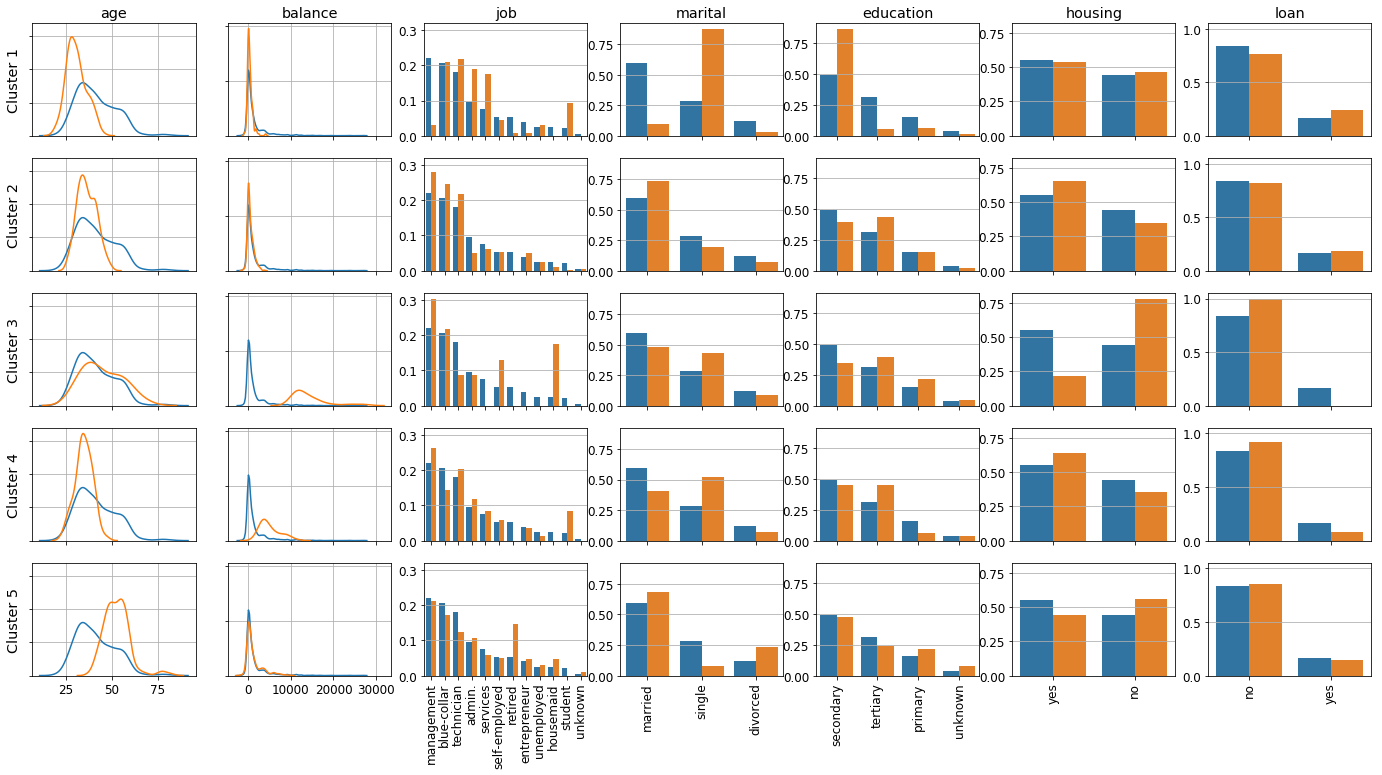

In [15]:
from scipy import stats
import seaborn as sns

f, axes = plt.subplots(K, n_features, figsize=(24, 12), sharex='col', sharey='col')

cols = [x for x in num_col_names]
cols += [x for x in cat_col_names]
rows = ['Cluster {}'.format(i+1) for i in np.arange(K)]


for i, label in enumerate(set(labels)):
    n = df.iloc[labels==label].shape[0]
  

    col_idx = 0
    for col in num_col_names:
        sns.distplot(df[[col]], hist=False, rug=False, label="All", ax=axes[i-1, col_idx]);
        chart = sns.distplot(df.iloc[labels==label][[col]], hist=False, rug=False, label="Cluster {}".format(label), ax=axes[i-1,col_idx]);
        chart.set_yticklabels([])
        col_idx=col_idx+1
    for col in cat_col_names:
        
        # It's a bit complicated, and it took me a while to figure out, but what we're doing here is this:
        # Finding out the (normalized) distribution of each level for "all data"
        # Finding out the (normalized) distribution fo each level for this cluster
        # Plotting both on a bar chart
        
        all_prop_df = (df[col].value_counts(normalize=True).reset_index())
        all_prop_df['Cluster']= 'All'

        prop_df = (df.iloc[labels==label][col]
           .value_counts(normalize=True)
           .reset_index())

        prop_df['Cluster']= 'Cluster {}'.format(label)

        prop_df = pd.concat([all_prop_df, prop_df])
        prop_df = prop_df.reset_index(drop=True)

        chart = sns.barplot(x='index', y=col, hue='Cluster', data=prop_df, ci=None, ax=axes[i-1, col_idx])
        #chart.set_xticklabels(chart.get_xticklabels(), rotation=55)
        
        col_idx=col_idx+1

for ax1 in axes:
    for ax in ax1:
        ax.get_legend().remove()
        ax.set_ylabel('')
        ax.set_xlabel('')
        
for ax, col in zip(axes[0], cols):
    ax.set_title(col, size='large')

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

for j in np.arange(n_features):
    ax = axes[K-1,j]
    if j >= len(num_col_names): #Tmp hack to avoid rotating numeric lablels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
plt.show();
    